### Import packages & libraries

In [101]:
# Import libraries necessary for this project
import numpy as np   # linear algebra
from numpy import mean
from numpy import std
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from time import time
from tqdm import tqdm
import math
import gc
import os   # accessing directory structure
import requests
from io import StringIO
from timeit import default_timer as timer

# Import visualisation libraries
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')   # Define a plotting style to be used for all plots in this notebook
from mpl_toolkits.mplot3d import Axes3D

# Pretty display for notebooks
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Import Sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVR


# Import further data processing algorithms
import xgboost as xgb 
import catboost as cat
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

RSEED=50

---
### Import Train and Test datasets

In [2]:
train_zindi = pd.read_csv("data/Train.csv")
test_zindi = pd.read_csv("data/Test.csv")
sample_sub = pd.read_csv("data/sample_sub.csv")
airqo_metadata = pd.read_csv("data/airqo_metadata.csv")


In [3]:
# Airqo_metada provides additional background information about the location (A->E) and features of the parish in which each sensor is located
airqo_metadata.head()

,Unnamed: 0,location,loc_altitude,km2,aspect,dist_motorway,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste
0,0,A,1122.4,1.9,194.0,NaN,NaN,14.695789,343.595039,575.917422,330.609776,254.307415,4763,809,508,43,142
1,1,B,1155.4,5.4,219.8,NaN,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809,22243,5735,116,1144,239
2,2,C,1178.3,8.5,168.7,NaN,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350,97895,26873,21316,751,9835
3,3,D,980.8,0.8,90.0,NaN,NaN,265.896472,NaN,339.693908,76.024389,11.601442,3596,663,7,651,99
4,4,E,1186.5,1.6,121.0,NaN,850.423131,NaN,1738.872942,137.722087,449.591885,3.836589,6064,1297,985,26,43


In [4]:
train_zindi.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [5]:
train_zindi.shape

(15539, 9)

In [6]:
# covert features  fronm string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train_zindi[feature]=train_zindi[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test_zindi[feature]=test_zindi[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])    

In [7]:
train_zindi.head()
# It seems that the time series of each weather factor is stored as comma separated string

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",45.126304
1,ID_train_1,D,"[22.53333333, 21.71666667, 20.83333333, 20.983...","[0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...","[0.744583333, 0.808083333, 0.911166667, 0.9163...","[281.6643101, 89.15629262, 81.96853891, 291.01...","[2.3775, 1.126666667, 0.700833333, 0.341666667...","[90.32, 90.3775, 90.44083333, 90.4725, 90.4541...",79.131702
2,ID_train_10,A,"[28.975, 27.95, 29.6, 26.425, 22.09166667, 21....","[0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...","[0.573333333, 0.597166667, 0.5668333329999999,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[88.55166667, 88.46416667, 88.31916667, 88.24,...",32.661304
3,ID_train_100,A,"[22.96666667, 24.26666667, 25.275, 25.625, 25....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...","[0.8430833329999999, 0.79025, 0.7375, 0.728, 0...","[300.0850574, 293.6769595, 294.5174647, 301.92...","[1.446666667, 1.1925, 1.324166667, 1.544166666...","[88.615, 88.53083333, 88.4, 88.27166667, 88.20...",53.850238
4,ID_train_1000,A,"[21.875, 21.575, 21.525, 21.43333333, 20.50833...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8564166670000001, 0.874916667, 0.879833333,...","[21.83997432, 17.05405341, 89.26406044, 123.58...","[0.1975, 0.244166667, 0.411666667, 0.56, 0.577...","[88.55666667, 88.64083333, 88.65833333, 88.647...",177.418750


In [8]:
test_zindi.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press
0,ID_test_0,C,"[23.96666667, 22.88333333, 22.28333333, 21.483...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6898333329999999, 0.722333333, 0.7755833329...","[290.1352379, 328.47011289999995, 323.5730796,...","[0.6333333329999999, 0.725, 0.955, 0.8725, 0.6...","[87.64333333, 87.67, 87.70583333, 87.75083333,..."
1,ID_test_1,C,"[18.99166667, 19.70833333, 20.95833333, 22.783...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.99975, 0.99725, 0.956333333, 0.851583333, 0...","[295.2350543, 307.6569135, 313.7360236, 311.51...","[0.640833333, 1.244166667, 1.284166667, 1.2875...","[87.8925, 87.95666667, 87.9925, 87.9925, 87.98..."
2,ID_test_10,D,"[25.11666667, 25.08333333, 24.40833333, 23.575...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.760166667, 0.733583333, 0.78475, 0.82583333...","[77.06161145, 95.48124997, 61.44498258, 89.468...","[2.0133333330000003, 1.3025, 0.783333333, 0.53...","[90.34, 90.2975, 90.305, 90.35583333, 90.4425,..."
3,ID_test_100,C,"[18.71666667, 20.60833333, 22.28333333, 23.983...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.604...","[0.951416667, 0.92575, 0.8603333329999999, 0.7...","[310.7509058, 316.186793, 324.8167326, 327.217...","[0.745, 1.169166667, 1.316666667, 1.385, 1.400...","[87.98833333, 88.06333333, 88.07833333, 88.036..."
4,ID_test_1000,D,"[17.63333333, 18.05833333, 19.625, 21.28333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9, 0.898333333, 0.8725, 0.831666667, 0.8208...","[334.6054069, 329.6848561000001, 322.7668036, ...","[0.620833333, 0.5, 0.456666667, 0.558333333, 1...","[90.515, 90.5575, 90.62333333, 90.6825, 90.679..."


### Features engineering

In [9]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [10]:
data=pd.concat([train_zindi,test_zindi],sort=False).reset_index(drop=True)
data.columns.tolist()

['ID',
 'location',
 'temp',
 'precip',
 'rel_humidity',
 'wind_dir',
 'wind_spd',
 'atmos_press',
 'target']

In [11]:
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

In [12]:
data.shape

(20574, 735)

In [13]:
len(data.precip[10])

121

In [14]:
for col_name in tqdm(features):
    data[col_name]=data[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


In [15]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


In [16]:
data.drop(features,1,inplace=True)

In [17]:
train_zindi = data[data.target.notnull()].reset_index(drop=True)
test_zindi = data[data.target.isna()].reset_index(drop=True)

In [18]:
del data  
gc.collect()

0

Each sample in both train and test provided datasets has a 121 hour readings of weather factors including:

- Temperature
- Percipiation
- Relative humidity
- Wind speed 
- Wind direction
- Atmospheric pressure

The readings are recorded from 5 different locations in Uganda.

In [19]:
train_zindi.head()

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_train_0,C,45.126304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155268,0.666250,1.355000,87.871667,87.614167,87.752434,0.070374,0.004952,87.762083,0.257500
1,ID_train_1,D,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
2,ID_train_10,A,32.661304,28.975000,0.000,0.573333,NaN,NaN,88.551667,27.950000,...,0.342484,0.942500,2.420000,88.813333,87.982500,88.420931,0.179481,0.032213,88.425000,0.830833
3,ID_train_100,A,53.850238,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,24.266667,...,0.336701,1.388333,2.469167,88.685000,87.965000,88.376915,0.161758,0.026166,88.400000,0.720000
4,ID_train_1000,A,177.418750,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,21.575000,...,0.181690,0.542917,1.796667,88.719167,88.268333,88.538104,0.118369,0.014011,88.552500,0.450833


In [20]:
test_zindi.head()
# Target variable is given as column, however all entires are NaN values

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_test_0,C,NaN,23.966667,0.0,0.689833,290.135238,0.633333,87.643333,22.883333,...,0.154279,0.767500,1.744167,88.020833,87.474167,87.748506,0.132764,0.017626,87.752500,0.546667
1,ID_test_1,C,NaN,18.991667,0.0,0.999750,295.235054,0.640833,87.892500,19.708333,...,0.208605,0.771667,1.889167,88.181667,87.572500,87.936963,0.113756,0.012940,87.928333,0.609167
2,ID_test_10,D,NaN,25.116667,0.0,0.760167,77.061611,2.013333,90.340000,25.083333,...,0.324600,0.567500,2.890000,90.785000,90.115000,90.521357,0.136316,0.018582,90.536667,0.670000
3,ID_test_100,C,NaN,18.716667,0.0,0.951417,310.750906,0.745000,87.988333,20.608333,...,0.185370,0.685000,1.575000,88.078333,87.560000,87.754848,0.125583,0.015771,87.726667,0.518333
4,ID_test_1000,D,NaN,17.633333,0.0,0.900000,334.605407,0.620833,90.515000,18.058333,...,0.193861,0.609091,1.761667,90.798333,90.105833,90.475030,0.161193,0.025983,90.487273,0.692500


In [21]:
# Print shape of datasets
print('Train data')
print('# train:  {}'.format(train_zindi.shape))
print('==================')
print('Test data')
print('# test_zindi:  {}'.format(test_zindi.shape))

Train data
# train:  (15539, 771)
Test data
# test_zindi:  (5035, 771)


---
### (Optional) Merging airqo and train data (tbd)
-> not sure if this step is necessary <br>
-> You have to perform a left join with the original dataframe by using location as the key. Obviously the NaN values will be replicated after joining.

---
### Encoding variable 'location' (tbc)

In [22]:
# It encodes labels with value between 0 and n_classes-1
#This transformer should be used to encode target values, i.e. y, and not the input X (ask the coaches)

from sklearn.preprocessing import LabelEncoder
lab  = LabelEncoder()

lab.fit(train_zindi["location"])

train_zindi.location  = lab.transform(train_zindi.location)
test_zindi.location  = lab.transform(test_zindi.location)

train_zindi.target.min(),train_zindi.target.max()

(1.4526190476190477, 475.82)

A -> 0 <br>
B -> 1 <br>
C -> 2 <br>
D -> 3 <br>
E -> 4

In [23]:
train_zindi.head(8)

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_train_0,2,45.126304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155268,0.666250,1.355000,87.871667,87.614167,87.752434,0.070374,0.004952,87.762083,0.257500
1,ID_train_1,3,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
2,ID_train_10,0,32.661304,28.975000,0.000,0.573333,NaN,NaN,88.551667,27.950000,...,0.342484,0.942500,2.420000,88.813333,87.982500,88.420931,0.179481,0.032213,88.425000,0.830833
3,ID_train_100,0,53.850238,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,24.266667,...,0.336701,1.388333,2.469167,88.685000,87.965000,88.376915,0.161758,0.026166,88.400000,0.720000
4,ID_train_1000,0,177.418750,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,21.575000,...,0.181690,0.542917,1.796667,88.719167,88.268333,88.538104,0.118369,0.014011,88.552500,0.450833
5,ID_train_10000,4,17.005000,26.225000,0.000,0.756667,NaN,NaN,88.565833,26.250000,...,0.282313,1.075000,3.122500,88.746667,88.097500,88.437645,0.147604,0.021787,88.420833,0.649167
6,ID_train_10001,2,53.100000,21.866667,0.000,0.548333,334.082716,1.152500,87.736667,21.383333,...,0.198869,0.893333,1.884167,87.961667,87.472500,87.717645,0.121492,0.014760,87.729167,0.489167
7,ID_train_10002,0,55.051143,28.241667,0.000,0.527250,328.461619,1.926667,88.014167,27.900000,...,0.226285,0.716667,1.919167,88.511667,87.838333,88.212652,0.169373,0.028687,88.235000,0.673333


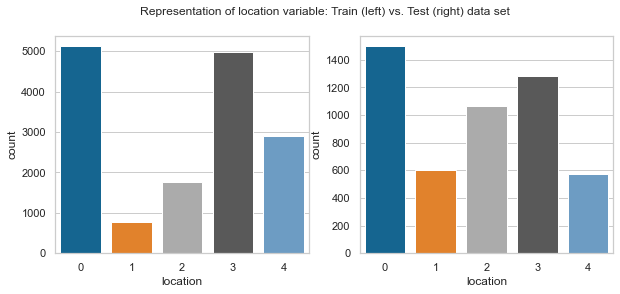

In [24]:
# Visualize frequency of variable 'location' on y_train and y_test datasets
# As shown, numbers of entries in DF with respect of the location are unequal

fig, axes = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle("Representation of location variable: Train (left) vs. Test (right) data set")
sns.countplot(x=train_zindi['location'], ax=axes[0]);
sns.countplot(x=test_zindi['location'], ax=axes[1]);

It seems that data were collected non-uniformly from locations

--- 
### Defining features and target variables - Train-Test split

The target variable of each sample represents PM2.5 index measured 24 hours after the last weather readings

In [25]:
# train-test-split
df_train, df_test= train_test_split(train_zindi, test_size=0.3, random_state=RSEED)

# Split train set into features and target 
X_train = df_train.drop(['ID', 'target'], axis=1)
y_train = df_train['target']
print(X_train.shape)

# Split test set into features and target
X_test = df_test.drop(['ID', 'target'], axis=1)
y_test = df_test['target']
print(X_test.shape) 

(10877, 769)
(4662, 769)


--- 
### Carry out first EDA on training data

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10877 entries, 5996 to 14000
Columns: 771 entries, ID to ptp_atmos_press
dtypes: float64(769), int64(1), object(1)
memory usage: 64.1+ MB


In [27]:
df_train.shape

(10877, 771)

In [28]:
df_train.describe()

,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,newprecip1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
count,10877.000000,10877.000000,10128.000000,10108.000000,10135.000000,9642.000000,9642.000000,10159.000000,10139.000000,10122.00000,...,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000,10877.000000
mean,1.985934,58.183457,22.940257,0.165002,0.788909,199.421624,1.044101,89.075211,22.937070,0.17371,...,0.336676,0.926602,2.616752,89.339680,88.700674,89.038673,0.145792,0.021699,89.047048,0.639005
std,1.564033,42.126087,3.625090,1.392901,0.151850,110.309492,0.754266,1.107773,3.612749,1.43220,...,0.305337,0.622682,1.533650,1.097232,1.045037,1.075152,0.021064,0.006399,1.076808,0.110823
min,0.000000,1.452619,13.783333,0.000000,0.251500,0.012510,0.123333,87.250000,13.783333,0.00000,...,0.017159,0.393333,0.509167,87.871667,87.250000,87.605399,0.069121,0.004778,87.597500,0.257500
25%,0.000000,33.438718,20.000000,0.000000,0.681542,108.561261,0.521667,88.287500,19.991667,0.00000,...,0.184556,0.679167,1.845833,88.615833,88.003333,88.340750,0.131211,0.017216,88.352500,0.567500
50%,3.000000,46.543478,22.283333,0.000000,0.817667,195.598965,0.845833,88.511667,22.258333,0.00000,...,0.269453,0.765833,2.353333,88.757500,88.186667,88.477760,0.144859,0.020984,88.485833,0.634167
75%,3.000000,68.536667,25.583333,0.000000,0.912833,306.486727,1.355000,90.450833,25.591667,0.00000,...,0.403199,0.940417,3.051667,90.819167,90.066667,90.479663,0.158666,0.025175,90.490000,0.702500
max,4.000000,447.340000,35.683333,43.080000,1.000000,359.997383,15.607500,91.130833,35.683333,43.08000,...,6.681586,5.613333,24.659167,91.130833,90.503333,90.807583,0.269509,0.072635,90.817500,1.033333


In [29]:
df_train.columns

Index(['ID', 'location', 'target', 'newtemp0', 'newprecip0',
       'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0',
       'newtemp1',
       ...
       'var_wind_spd', 'median_wind_spd', 'ptp_wind_spd', 'max_atmos_press',
       'min_atmos_press', 'mean_atmos_press', 'std_atmos_press',
       'var_atmos_press', 'median_atmos_press', 'ptp_atmos_press'],
      dtype='object', length=771)

In [30]:
# Print all colums variables as a list
# print(train.columns.values.tolist())

In [31]:
#print(train['ID'].tolist())

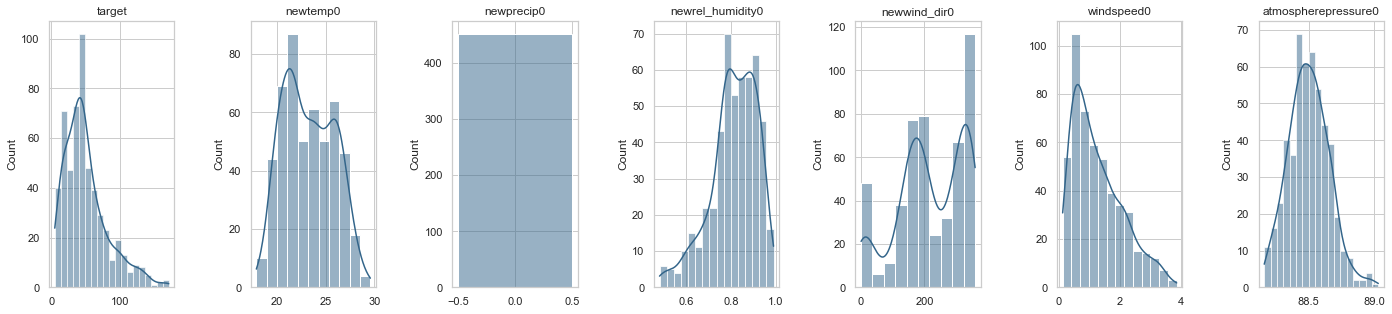

In [32]:
# As a foretaste, let's plot the distribution of features for only one data entry, e.g. <variablename_0>, including the target variable
# Plot will be make for only location 0 (A)


plot_col = ['target', 'newtemp0', 'newprecip0', 'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0']
fig,ax = plt.subplots(1, 7,figsize=(20,5))
count = 0
for col in plot_col:
    sns.histplot(df_train.query("location==1")[col], kde=True, ax=ax[count], color='#33658A').set(title=col, xlabel='')
    count += 1
fig.tight_layout(pad=3)

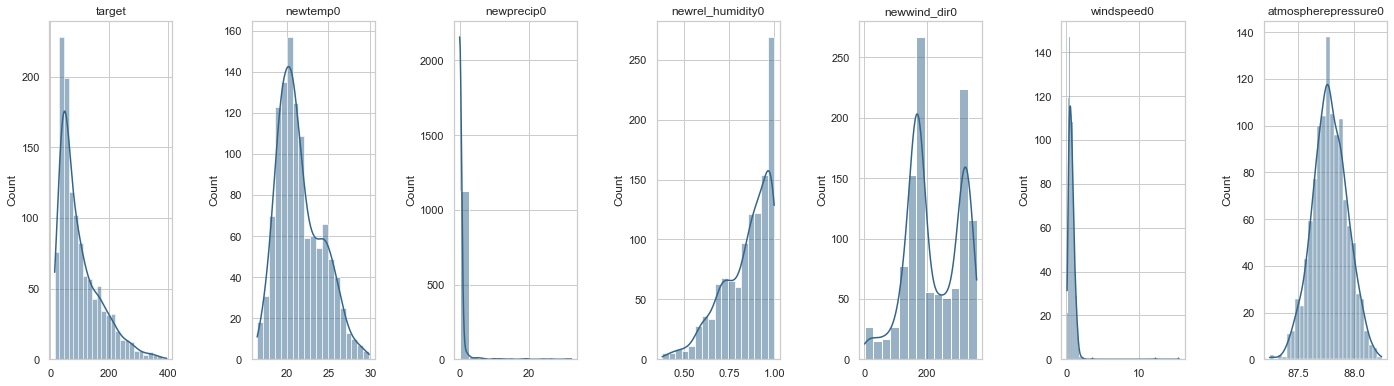

In [33]:
# Here example for location == 2 (C)
plot_col = ['target','newtemp0', 'newprecip0', 'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0']
fig,ax = plt.subplots(1, 7,figsize=(20,6))
count = 0
for col in plot_col:
    sns.histplot(df_train.query("location==2")[col], kde=True, ax=ax[count], color='#33658A').set(title=col, xlabel='')
    count += 1
fig.tight_layout(pad=3)

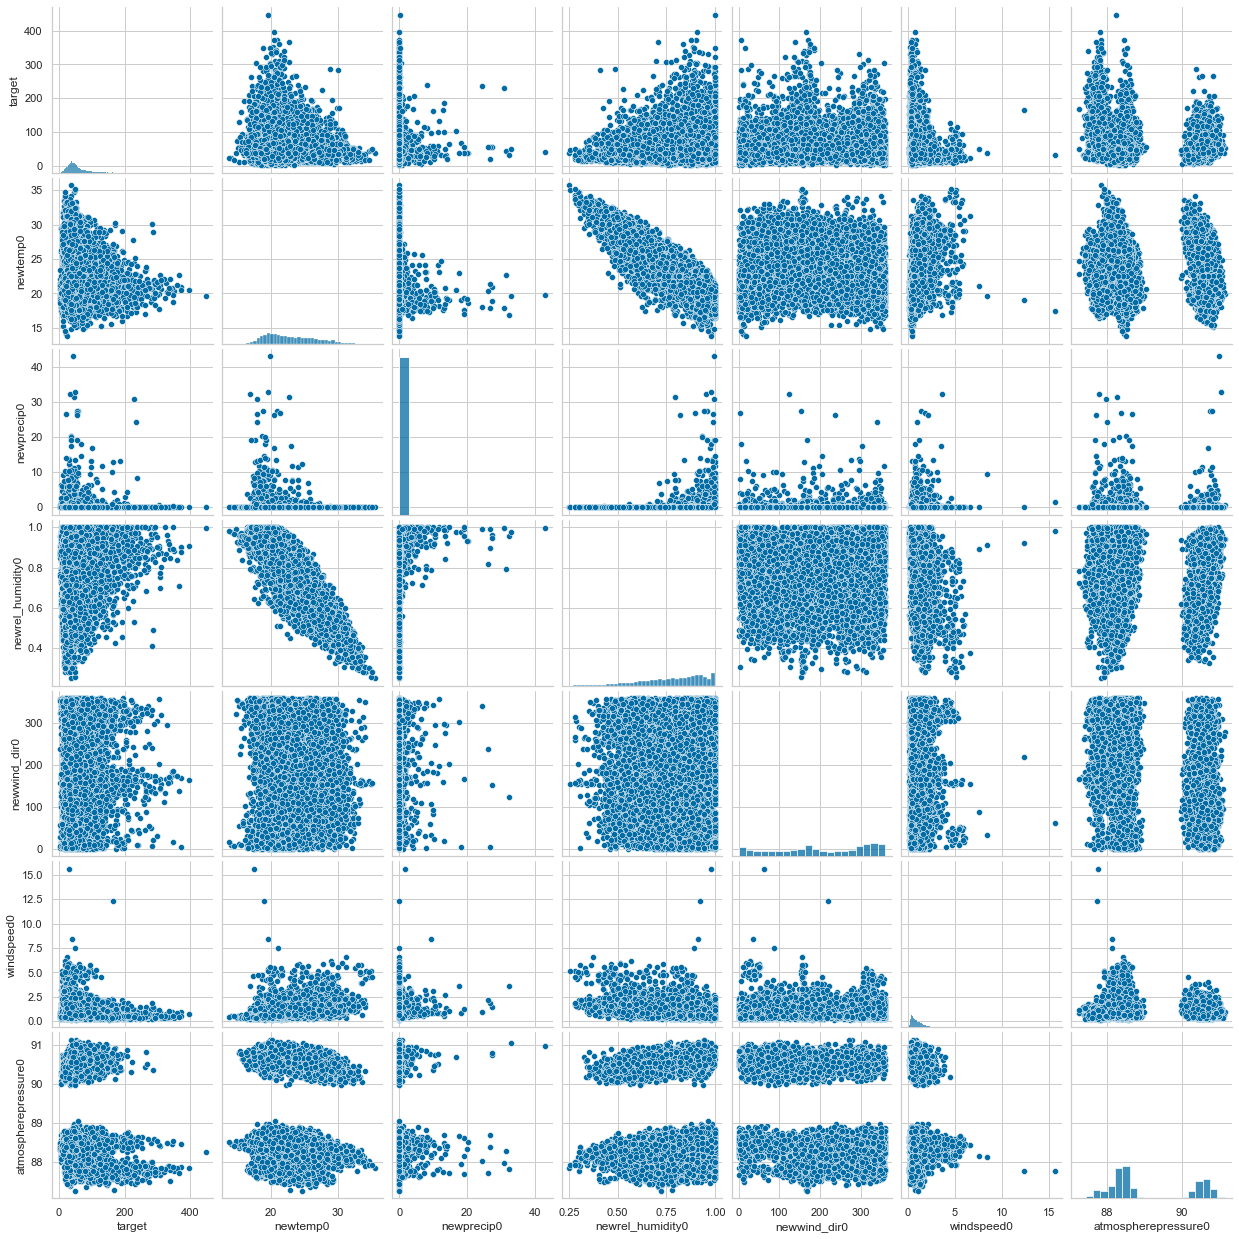

In [34]:
# Ploting and calculating correlations between features
# example plot for only one time stamp entry

sns.pairplot(df_train[['target', 'newtemp0', 'newprecip0', 'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0']]);

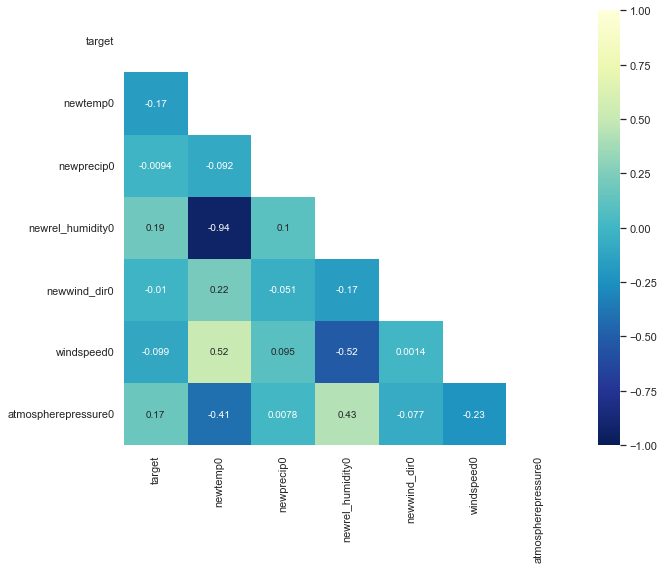

In [35]:
# Calculate correlations between features and target, only for one time stamp measured entry
train_A = df_train.query("location == 0")
train_A = train_A.iloc[:,2:9]

corr = train_A.corr()

plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap="YlGnBu_r", mask=mask, vmax=1, vmin=-1);

--- 
### (Optional) Adjust the data frame (tbd)

In [36]:
# Getting smaller train data frame with only location==A
#train_A = train.query("location == 'A'")
#train_A.shape

In [37]:
# Slicing the train data frame, taking only the first 20 columns
#train_A = train_A.iloc[:,750:771]
#train_A.head()

In [38]:
#print(train_A['ID'].tolist())

--- 
### Imputing NaN values

- Since the data is a hourly average of weather indicators for 5 days (total 121 hours), a good approach might be for dealing with such NaN values 
is by looping through the list and averaging it on hour basis, maybe 8 hours interval or so
- On the other hand, it is better to not include more noise to the model and not fill null values with mean, median, mode in this particular problem statement
- In addition, if the selected model is lightgbm or similar packages (Boosting methods) they can handle NaN values by default quite well, for this reason we would suggest to leave them as it is

In [39]:
df_train.isnull().sum().sort_values(ascending=False)

newwind_dir0         1235
windspeed0           1235
windspeed2           1221
newwind_dir2         1221
windspeed1           1220
                     ... 
ptp_precip              0
max_rel_humidity        0
min_rel_humidity        0
mean_rel_humidity       0
ptp_atmos_press         0
Length: 771, dtype: int64

---
### Scaling the data
Discuss with Martins if this step is needed in our case, maybe not since we are not imputing the NaN values<br>
Scaling to be applied only to the features. Two option are available: normalization and standardization

In [40]:
# Code example for Standardizing the features
# Standardizing the data
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [91]:
# example for carrying out standardization 
'''
time_series_feat = np.concatenate([train_time_series_feat, test_time_series_feat], axis = 0)

#data standardization
for c in range(time_series_feat.shape[2]):
    valid_idx = np.where(time_series_feat[:,:,c] != -100) #don't include missing values in normalization
    mean = time_series_feat[:,:,c][valid_idx].mean()
    std = time_series_feat[:,:,c][valid_idx].std()
    
    time_series_feat[:,:,c][valid_idx] -= mean
    time_series_feat[:,:,c][valid_idx] /= std

train_time_series_feat = time_series_feat[:train_loc.shape[0]]
test_time_series_feat = time_series_feat[train_loc.shape[0]:]
'''

"\ntime_series_feat = np.concatenate([train_time_series_feat, test_time_series_feat], axis = 0)\n\n#data standardization\nfor c in range(time_series_feat.shape[2]):\n    valid_idx = np.where(time_series_feat[:,:,c] != -100) #don't include missing values in normalization\n    mean = time_series_feat[:,:,c][valid_idx].mean()\n    std = time_series_feat[:,:,c][valid_idx].std()\n    \n    time_series_feat[:,:,c][valid_idx] -= mean\n    time_series_feat[:,:,c][valid_idx] /= std\n\ntrain_time_series_feat = time_series_feat[:train_loc.shape[0]]\ntest_time_series_feat = time_series_feat[train_loc.shape[0]:]\n"

---
### Histogram

NameError: name 'train' is not defined

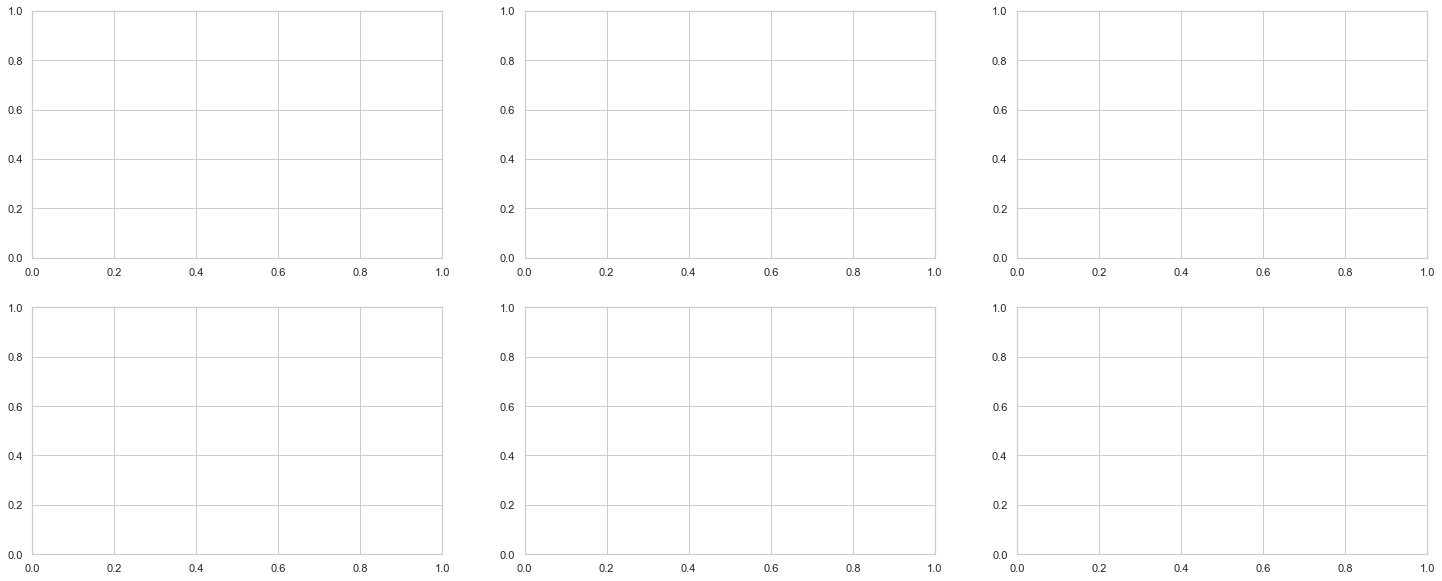

In [41]:
rng = np.arange(121)

fig, axs = plt.subplots(2, 3, figsize=(25,10))

valid_idx = np.where(train[:,:,0] != -100)
axs[0, 0].hist(train[:,:,0][valid_idx].flatten(), bins=100)
axs[0, 0].set(xlabel='Temp', ylabel='Number of samples')
valid_idx = np.where(train[:,:,1] != -100)
axs[0, 1].hist(train[:,:,1][valid_idx].flatten(), bins=100)
axs[0, 1].set(xlabel='Precipitation', ylabel='Number of samples')
valid_idx = np.where(train[:,:,2] != -100)
axs[0, 2].hist(train[:,:,2][valid_idx].flatten(), bins=100)
axs[0, 2].set(xlabel='Relative humidity', ylabel='Number of samples')
valid_idx = np.where(train[:,:,3] != -100)
axs[1, 0].hist(train[:,:,3][valid_idx].flatten(), bins=100)
axs[1, 0].set(xlabel='Wind Direction', ylabel='Number of samples')
valid_idx = np.where(train[:,:,4] != -100)
axs[1, 1].hist(train[:,:,4][valid_idx].flatten(), bins=100)
axs[1, 1].set(xlabel='Wind Speed', ylabel='Number of samples')
valid_idx = np.where(train[:,:,5] != -100)
axs[1, 2].hist(train[:,:,5][valid_idx].flatten(), bins=100)
axs[1, 2].set(xlabel='Atmospheric Pressure', ylabel='Number of samples')


fig.suptitle('Histograms of Weather Factors')
print()

--- 
### Replacing NaN using pipelines

In [45]:
# It runs forever, better not to use it

pipe = Pipeline((
("it", IterativeImputer()),
("pt", PowerTransformer()),
("sc", StandardScaler()),
("xb", xgb()),
#("kn", KNeighborsClassifier()),
#("dt", DecisionTreeClassifier(random_state=RSEED))
))
pipe.fit(X_train,y_train)
print("Testing Accuracy : ", pipe.score(X_test,y_test))
print("Training Accuracy: ", pipe.score(X_train,y_train))

TypeError: 'module' object is not callable

---
## Predictive Modeling building and testing

Before start modelling it is a best practice to define a evaluation metric most appropriate for our case. In our challenge, the RMSE is already given as part of the requirements by ZINDI

---
### Baseline Model

This baseline model represents a educated guess and acts as a benchmark for any further models to beat. Since we are facing a pseudo-time series problem, there two possible ways to set a baseline:

- By using a dummy regressor, which brings other problems like dealing with NaNs
- Compute a y_pred using a average value of the target

In [46]:
# Optional: create a baseline 
'''
# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')

# fit it on the training set
dummy_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = dummy_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Dummy RMSE:", rmse)
'''

'\n# create a dummy regressor\ndummy_reg = DummyRegressor(strategy=\'mean\')\n\n# fit it on the training set\ndummy_reg.fit(X_train, y_train)\n\n# make predictions on the test set\ny_pred = dummy_reg.predict(X_test)\n\n# calculate root mean squared error\nmse = mean_squared_error(y_test, y_pred)\nrmse = np.sqrt(mse)\nprint("Dummy RMSE:", rmse)\n'

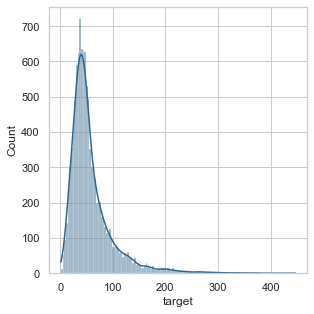

In [89]:
# Plot target variable to see its skewness
fig,ax = plt.subplots(1,figsize=(5,5))
sns.histplot(df_train['target'], color='#33658A', kde=True)
fig.tight_layout(pad=3)

In [67]:
# Based on the skewed data distribution of the target variable, we will take the median value for calculating the Baseline 
y_pred = df_train['target'].median()
print(y_pred)


46.54347826086958


In [68]:
# Calculate the RMSE for our Baseline

# We need a list with the length of y
y_train_pred = [y_pred] * len(y_train)
y_test_pred = [y_pred] * len(y_test)

# Calculate the mean_squared_error
mse_train = mean_squared_error(y_train,y_train_pred)
mse_test = mean_squared_error(y_test,y_test_pred)

RMSE_train = np.sqrt(mse_train)
RMSE_test = np.sqrt(mse_test)

In [69]:
print(RMSE_train, RMSE_test)

43.70278190612329 44.54681860069472


---
### code steps example

In [ ]:
# Defining parameter grid (as dictionary)
param_grid = {"loss" : ["hinge", "log", "squared_hinge", "modified_huber"], #this actually defines the model you use
              "alpha" : [0.0001, 0.001, 0.01, 0.1],
              "penalty" : ["l2", "l1", "none"]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(SGDClassifier(random_state=RSEED), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
start = timer()
gs.fit(X_train_preprocessed, y_train)
end = timer()

In [ ]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

In [ ]:
# Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
sgd_best = gs.best_estimator_

# Making predictions on the test set
y_pred_test = sgd_best.predict(X_test_preprocessed)
# Let us print out the performance of our model on the test set.
sgd_accuracy = print_pretty_summary('SGDClassifier model', sgd_best, y_test, y_pred_test)

---
### Cross validation strategy (Kfold,or simple train test split )
Expected results for CV based on ZINDI forum -> 25
We can try Kfold method with 20 folds

The base model is first trained using a 3-fold cross validation to generate out-of-fold predictions and identify optimal number of boosting rounds. It is then trained on the full train set and it is this model that is used to make predictions on the test set. Both out-of-fold and test predictions are made on each of the 121 series and averaged to give the mean value of the target.

In [ ]:
# How to use 
# kfold

In [ ]:
# coding gave by martins

errcb2=[]
y_pred_totcb2=[]

fold=KFold(n_splits=20)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostRegressor(n_estimators=500,eval_metric='RMSE',learning_rate=0.2, random_seed= 1234, use_best_model=True )
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)#erly100
    preds=m2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict(test.drop(["ID"],axis = 1))
    y_pred_totcb2.append(p2)
np.mean(errcb2)

--- 
### Hyperparameter Tuning of Light Gradient Boost Model (LGBM)

Implementation of the LGBM model that was used as a base model

In [ ]:
# parameter grid example
param_grid = {"loss" : ["hinge", "log", "squared_hinge", "modified_huber"], #this actually defines the model you use
              "alpha" : [0.0001, 0.001, 0.01, 0.1],
              "penalty" : ["l2", "l1", "none"]
             }

In [97]:
# create dataset for lightgbm
lgb_train = lgbm.Dataset(X_train, y_train)
lgb_eval = lgbm.Dataset(X_test, y_test, reference=lgb_train)

# Defining parameter grid (as dictionary)
lgbm_params = {'boosting_type': ['gbdt','dart','rf'],
    'num_leaves': range(0,250,50) , # recommended 255
    'learning_rate': range(0.05,2),  # recommended 0.08
    'objective': 'regression',
    'n_estimators': range(20,200,20),
    'colsample_bytree': 0.8,
    'min_data_per_leaf': 25,
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
    "metric": "rmse",
    'n_jobs': -1,
    'random_state': RSEED
}



lgbm_model = lgbm.train(lgbm_params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)



# Training/fitting the model
lgbm_model = lgbm.train(lgbm_params, lgb_train,
                          num_boost_round = 100000,
                          early_stopping_rounds = 1000, 
                          valid_sets = [train_set, val_set], 
                          verbose_eval = 2000)

# Instantiate gridsearch and define the metric to optimize 
#gs = GridSearchCV(SGDClassifier(random_state=RSEED), param_grid, scoring='accuracy', cv=5, verbose=5, n_jobs=-1)

# Passing model, parametergrid and 5-fold cross validation to GridSearchCV
#dec_tree_gs = GridSearchCV(lgbm(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1, scoring=ftwo_scorer)

# Fitting GridSearchCV will output all parameters passed
#dec_tree_gs.fit(X_train_scaled_ros, y_train_ros)


# lgbm_model.best_iteration_
# lgbm_model.best_score_
# lgbm_model.evals_result_
# lgbm_model.feature_name_

IndentationError: unexpected indent (1453107292.py, line 28)

--- 
### Hyperparameter Tuning of CatBoost
Implementation of the CATBOOST model that was used as a meta learner

In [ ]:
# Defining parameter grid (as dictionary)

catb_params = dict(n_estimators=10000,
                    learning_rate=0.2, 
                    random_seed=RSEED)

catb_model = CatBoostRegressor(eval_metric='RMSE',
                                  use_best_model=True,
                                    **params)

catb_model.fit(X_train, y_train,
                  eval_set=[xy_train, xy_val],
                  early_stopping_rounds=10,
                  verbose=20)

--- 
## Training the model / Model evaluation

In [ ]:
#y_train_pred = reg.predict(X_train)
#mse = mean_squared_error(y_train, y_train_pred)
#print(mse)

#sklearn.metrics has a mean_squared_error function with a squared kwarg (defaults to True). Setting squared to False will return the RMSE.

In [ ]:
#training the model
#from sklearn.linear_model import LinearRegression
#reg = LinearRegression().fit(X_train, y_train)

---


---
### Ensemble Model
Winner -> algorithm is an LGBM + CATBOOST ensemble.......with Light Gradient Boost Model (LGBM) as the base model and CatBoost model as the meta-learner <br>
Rank 8 ->  XGB + LGB + CA....


Several algoritms are used to carry out a predictive modeling (regression OR classifier). In this case, we decided to treat the problem as a pseudo time-series where the algorithm learns the temporal nature of the data without any timestamp given. For this purpose, we utilize the idx features derived from the indices (positions) of the data points in their respective 5-day series using a stacked model to better learn the relationship between the meteorological variables and targ...

In [106]:
# example Implementation of Stacking in Scikit-Learn

estimators = [
    ('catb', CatBoostRegressor(random_state = RSEED)),
    ('lgbm', LGBMRegressor(random_state = RSEED))
]

reg = StackingRegressor(estimators = estimators, final_estimator = LGBMRegressor(n_estimators=10, random_state = RSEED))
reg.fit(X_train, y_train).score(X_test, y_test)

Learning rate set to 0.059696
0:	learn: 41.4322124	total: 65.4ms	remaining: 1m 5s
1:	learn: 40.7766682	total: 109ms	remaining: 54.4s
2:	learn: 40.2119901	total: 153ms	remaining: 51s
3:	learn: 39.6811406	total: 206ms	remaining: 51.4s
4:	learn: 39.1759299	total: 263ms	remaining: 52.2s
5:	learn: 38.7085877	total: 325ms	remaining: 53.8s
6:	learn: 38.2731259	total: 387ms	remaining: 55s
7:	learn: 37.8428585	total: 445ms	remaining: 55.2s
8:	learn: 37.4503640	total: 499ms	remaining: 55s
9:	learn: 37.0781613	total: 539ms	remaining: 53.3s
10:	learn: 36.7611365	total: 568ms	remaining: 51.1s
11:	learn: 36.4473019	total: 597ms	remaining: 49.1s
12:	learn: 36.1312534	total: 626ms	remaining: 47.5s
13:	learn: 35.8464925	total: 654ms	remaining: 46.1s
14:	learn: 35.5706290	total: 686ms	remaining: 45s
15:	learn: 35.3279302	total: 732ms	remaining: 45s
16:	learn: 35.0794007	total: 766ms	remaining: 44.3s
17:	learn: 34.8236027	total: 797ms	remaining: 43.5s
18:	learn: 34.5916746	total: 826ms	remaining: 42.7s
1

KeyboardInterrupt: 

---
### Metric evaluation (RMSE)

In [ ]:
from sklearn.metrics import mean_squared_error
def metric(y,x):
    return np.sqrt(mean_squared_error(x,y))

# solution with an rmse at least 38.42

# RMSE of test > RMSE of train => OVER FITTING of the data.
# RMSE of test < RMSE of train => UNDER FITTING of the data.‚

In [ ]:
def train_function(model,train,test,params,other_params,target_name,features,metric):
    folds_num=train.fold.nunique()
    validation=train[[id_name,"fold",target_name]].copy()
    validation["pred_"+target_name]=0
    sub=test[[id_name]].copy()
    sub[target_name]=0
    for fold in np.sort(train.fold.unique()):
        print("#"*50+" {} ".format(fold)+"#"*50)
        os.makedirs("model_save/lgbm/{}/{}".format(Experiment_name,str(int(fold))), exist_ok=True)
        X_train=train[train.fold!=fold]
        X_val=train[train.fold==fold]
        
        train_pred,validation_pred,test_pred=model(X_train,X_val,test,params,other_params)
        
        validation.loc[validation.fold==fold,"pred_"+target_name]=validation_pred
        sub[target_name]+=test_pred/folds_num
        train_score=metric(X_train[target_name],train_pred)
        val_score=metric(X_val[target_name],validation_pred)
        print("train score : {} validation score : {}".format(round(train_score,4),round(val_score,4)))
    final_validation_score=metric(validation[target_name],validation["pred_"+target_name])
    print("final validation score : {}".format(final_validation_score))
        
    return sub,validation,final_validation_score

def lgbm_model(X_train,X_val,X_test,params,other_params):
    dtrain = lgbm.Dataset(data=X_train[features], label=X_train[target_name], feature_name=features)
    dval = lgbm.Dataset(data=X_val[features], label=X_val[target_name], feature_name=features)

    model = lgbm.train(
        params=params,
        train_set=dtrain,
        num_boost_round=other_params["num_boost_round"],
        valid_sets=(dtrain, dval),
        early_stopping_rounds=other_params["early_stopping_rounds"],
        verbose_eval=other_params["verbose_eval"],
    )        
    best_iteration = model.best_iteration
    train_pred=model.predict(X_train[features], num_iteration=best_iteration)
    validation_pred=model.predict(X_val[features], num_iteration=best_iteration)
    test_pred=model.predict(test[features], num_iteration=best_iteration)
        
    return train_pred,validation_pred,test_pred

In [ ]:
other_params={"num_boost_round":50000000,
              "early_stopping_rounds":50,
              "verbose_eval":1000,
}
lgbm_params = {
    "bagging_fraction": 0.8,
    "bagging_freq": 2,
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,
    "learning_rate": 0.01,
    "max_depth": 8,
    "num_threads": 16,
    "objective": "regression",
    "metric": "rmse",
    "seed": 2020,
}

In [ ]:
sub,validation,score=train_function(model=lgbm_model,
                                    train=train,
                                    test=test,
                                    params=lgbm_params,
                                    other_params=other_params,
                                    target_name=target_name,
                                    features=features,
                                    metric=metric)

In [ ]:
os.makedirs("subs", exist_ok=True)

In [ ]:
sub.to_csv("./subs/lgbm_{}.csv".format(round(score,2)),index=False)